In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

By the way, a good estimate of the Monte Carlo bounds for a simulation study is based on that the replications of Y_i = I(Method does better than state of the art for data set i) = 1 if true or 0 otherwise is because the N = 40 data sets are Binomial(N, \pi) where \pi = Pr(Better than state of the art) and N is the number of data sets.  The variance of p = \sum Y_i / N [i.e. the proportion of times the method at least equals SotA performance] is (1 - \pi)\pi / N which can be estimated by (1 – p)p/N.  So you can construct an approximately normal interval around p by using ( p - 1.96 x sqrt{ (1 – p)p / N}, p + 1.96 x sqrt{(1 – p)p / N}  ).  

(See 9.1.27 and 9.1.29 here https://stats.libretexts.org/Bookshelves/Probability_Theory/Introductory_Probability_(Grinstead_and_Snell)/09%3A_Central_Limit_Theorem/9.01%3A_Central_Limit_Theorem_for_Bernoulli_Trials).

$$p = \frac{S_n}{N}$$
$$\sigma^2 = \frac{(1-p)p}{N}$$
$$\sigma = \sqrt{\frac{(1-p)p}{N}}$$
$$(p - 1.96 \times \sqrt{\frac{(1-p)p}{N}}) < p < (p + 1.96 \times \sqrt{\frac{(1-p)p}{N}})$$
$$(p - 1.96 \times \sigma) < p < (p + 1.96 \times \sigma)$$

In [63]:
def get_win_count(df, metric, threshold):
    iter_gr = df.groupby(['iter_id'], as_index=False)[[f'{metric}_val', f'{metric}_test']]
    iter_perfs = iter_gr.apply(lambda x: x.loc[x[f'{metric}_val'].idxmin(), [f'{metric}_test']])[f'{metric}_test'].to_numpy()
    return np.sum(iter_perfs <= threshold)

def parse_est_name(name):
    name = name.upper()
    if name == 'IPSWS':
        return 'IPSW'
    elif name == 'DRS':
        return 'DR'
    elif name == 'DMLS':
        return 'DML'
    else:
        return name
    
def parse_base_name(name):
    name = name.upper()
    if name == 'MLP':
        return 'NN'
    else:
        return name

def get_avg_probs(datasets, metrics, thresholds, estimators, base_learners):
    iter_per_dataset = 10
    n_dataset = len(datasets)
    mc_n = n_dataset * iter_per_dataset
    result = []
    for est in estimators:
        if est == 'cf':
            est_wins = 0
            for ds, metric, thr in zip(datasets, metrics, thresholds):
                df_test = pd.read_csv(f'../results/metrics_val/{ds}/{est}/{est}_test_metrics.csv')
                df_val = pd.read_csv(f'../results/metrics_val/{ds}/{est}/{est}_val_metrics.csv')
                df_val_gr = df_val.groupby(['iter_id', 'param_id'], as_index=False).mean().drop(columns=['fold_id'])
                df_base = df_val_gr.merge(df_test, on=['iter_id', 'param_id'], suffixes=['_val', '_test'])

                est_wins += get_win_count(df_base, metric, thr)
            win_prob = est_wins / mc_n
            var = ((1.0 - win_prob) * win_prob) / mc_n
            err = 1.96 * np.sqrt(var)
            result.append([parse_est_name(est), None, win_prob, err])
        else:
            for bl in base_learners:
                model_name = f'{est}_{bl}'

                est_wins = 0
                for ds, metric, thr in zip(datasets, metrics, thresholds):
                    try:
                        df_test = pd.read_csv(f'../results/metrics_val/{ds}/{model_name}/{model_name}_test_metrics.csv')
                        df_val = pd.read_csv(f'../results/metrics_val/{ds}/{model_name}/{model_name}_val_metrics.csv')
                        df_val_gr = df_val.groupby(['iter_id', 'param_id'], as_index=False).mean().drop(columns=['fold_id'])
                        df_base = df_val_gr.merge(df_test, on=['iter_id', 'param_id'], suffixes=['_val', '_test'])

                        est_wins += get_win_count(df_base, metric, thr)
                    except:
                        #print(f'Missing {model_name}')
                        continue
                win_prob = est_wins / mc_n
                var = ((1.0 - win_prob) * win_prob) / mc_n
                err = 1.96 * np.sqrt(var)
                result.append([parse_est_name(est), parse_base_name(bl), win_prob, err])
    
    cols = ['estimator', 'base learner', 'prob', 'err']
    df = pd.DataFrame(result, columns=cols)

    return df

def get_probs_est(datasets, metrics, thresholds, estimators, base_learners):
    iter_per_dataset = 10
    n_dataset = len(datasets)
    mc_n = n_dataset * iter_per_dataset
    result = []
    for est in estimators:
        if est == 'cf':
            est_wins = 0
            for ds, metric, thr in zip(datasets, metrics, thresholds):
                df_test = pd.read_csv(f'../results/metrics_val/{ds}/{est}/{est}_test_metrics.csv')
                df_val = pd.read_csv(f'../results/metrics_val/{ds}/{est}/{est}_val_metrics.csv')
                df_val_gr = df_val.groupby(['iter_id', 'param_id'], as_index=False).mean().drop(columns=['fold_id'])
                df_base = df_val_gr.merge(df_test, on=['iter_id', 'param_id'], suffixes=['_val', '_test'])

                est_wins += get_win_count(df_base, metric, thr)
            win_prob = est_wins / mc_n
            var = ((1.0 - win_prob) * win_prob) / mc_n
            err = 1.96 * np.sqrt(var)
            result.append([parse_est_name(est), win_prob, err])
        else:
            est_wins = 0
            mc_n_est = 0
            for bl in base_learners:
                model_name = f'{est}_{bl}'
                for ds, metric, thr in zip(datasets, metrics, thresholds):
                    try:
                        df_test = pd.read_csv(f'../results/metrics_val/{ds}/{model_name}/{model_name}_test_metrics.csv')
                        df_val = pd.read_csv(f'../results/metrics_val/{ds}/{model_name}/{model_name}_val_metrics.csv')
                        df_val_gr = df_val.groupby(['iter_id', 'param_id'], as_index=False).mean().drop(columns=['fold_id'])
                        df_base = df_val_gr.merge(df_test, on=['iter_id', 'param_id'], suffixes=['_val', '_test'])

                        est_wins += get_win_count(df_base, metric, thr)
                        mc_n_est += iter_per_dataset
                    except:
                        continue
            win_prob = est_wins / mc_n_est
            var = ((1.0 - win_prob) * win_prob) / mc_n_est
            err = 1.96 * np.sqrt(var)
            result.append([parse_est_name(est), win_prob, err])
    
    cols = ['estimator', 'prob', 'err']
    df = pd.DataFrame(result, columns=cols)

    return df

In [17]:
ihdp_ate_upper = 0.46
ihdp_ate_lower = 0.2
ihdp_pehe_upper = 2.6
ihdp_pehe_lower = 0.656

jobs_att_upper = 0.11
jobs_att_lower = 0.03
jobs_pol_upper = 0.26
jobs_pol_lower = 0.14

twins_pehe_upper = 0.315
twins_pehe_lower = 0.297

news_ate_upper = 0.6
news_ate_lower = 0.3
news_pehe_upper = 3.4
news_pehe_lower = 2.0

avg_upper = [ihdp_ate_upper, jobs_att_upper, news_ate_upper]
avg_lower = [ihdp_ate_lower, jobs_att_lower, news_ate_lower]

ind_upper = [ihdp_pehe_upper, jobs_pol_upper, twins_pehe_upper, news_pehe_upper]
ind_lower = [ihdp_pehe_lower, jobs_pol_lower, twins_pehe_lower, news_pehe_lower]

Missing ipsws_l2
Missing ipsws_et
Missing ipsws_kr
Missing ipsws_kr
Missing ipsws_mlp
Missing ipsws_mlp
Missing ipsws_mlp
Missing dmls_mlp
Missing dmls_mlp
Missing dmls_mlp
Missing drs_mlp
Missing drs_mlp
Missing drs_mlp
Missing xl_mlp
Missing xl_mlp
Missing xl_mlp
Missing ipsws_l2
Missing ipsws_l2
Missing ipsws_et
Missing ipsws_kr
Missing ipsws_kr
Missing ipsws_kr
Missing ipsws_mlp
Missing ipsws_mlp
Missing ipsws_mlp
Missing ipsws_mlp
Missing dmls_mlp
Missing dmls_mlp
Missing dmls_mlp
Missing dmls_mlp
Missing drs_mlp
Missing drs_mlp
Missing drs_mlp
Missing drs_mlp
Missing xl_mlp
Missing xl_mlp
Missing xl_mlp
Missing xl_mlp


<ErrorbarContainer object of 3 artists>

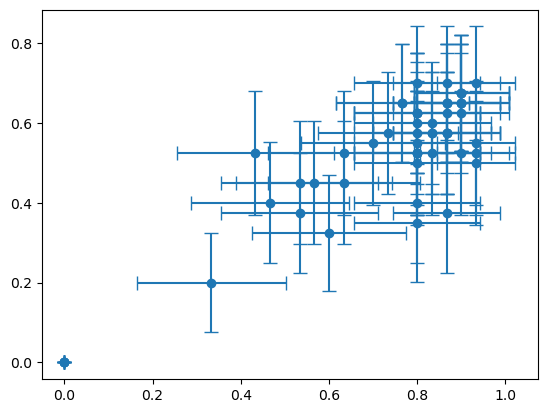

In [52]:
estimators = ['sl', 'tl', 'ipsws', 'dmls', 'drs', 'xl', 'cf']
base_learners = ['l1', 'l2', 'dt', 'rf', 'et', 'kr', 'lgbm', 'cb', 'mlp']
#estimators = ['sl', 'cf']
#base_learners = ['l1', 'l2']

datasets = ['ihdp', 'jobs', 'news']
metrics = ['ate', 'att', 'ate']

df_avg_match_sota = get_avg_probs(datasets, metrics, avg_upper, estimators, base_learners)
#df_avg_match_sota

datasets = ['ihdp', 'jobs', 'twins', 'news']
metrics = ['pehe', 'policy', 'pehe', 'pehe']

df_ind_match_sota = get_avg_probs(datasets, metrics, ind_upper, estimators, base_learners)
#df_ind_match_sota

df_match_sota = df_avg_match_sota.merge(df_ind_match_sota, on=['estimator', 'base learner'], suffixes=['_avg', '_ind'])
#df_match_sota

plt.errorbar(df_match_sota['prob_avg'], df_match_sota['prob_ind'], xerr=df_match_sota['err_avg'], yerr=df_match_sota['err_ind'], fmt='o', capsize=5)

In [55]:
df_match_sota.to_csv("./tables/prob_match_sota.csv", index=False)

In [64]:
estimators = ['sl', 'tl', 'ipsws', 'dmls', 'drs', 'xl', 'cf']
base_learners = ['l1', 'l2', 'dt', 'rf', 'et', 'kr', 'lgbm', 'cb', 'mlp']
#estimators = ['sl', 'cf']
#base_learners = ['l1', 'l2']

datasets = ['ihdp', 'jobs', 'news']
metrics = ['ate', 'att', 'ate']

df_avg_match_sota = get_probs_est(datasets, metrics, avg_upper, estimators, base_learners)
#df_avg_match_sota

datasets = ['ihdp', 'jobs', 'twins', 'news']
metrics = ['pehe', 'policy', 'pehe', 'pehe']

df_ind_match_sota = get_probs_est(datasets, metrics, ind_upper, estimators, base_learners)
#df_ind_match_sota

df_match_sota = df_avg_match_sota.merge(df_ind_match_sota, on=['estimator'], suffixes=['_avg', '_ind'])
#df_match_sota

<ErrorbarContainer object of 3 artists>

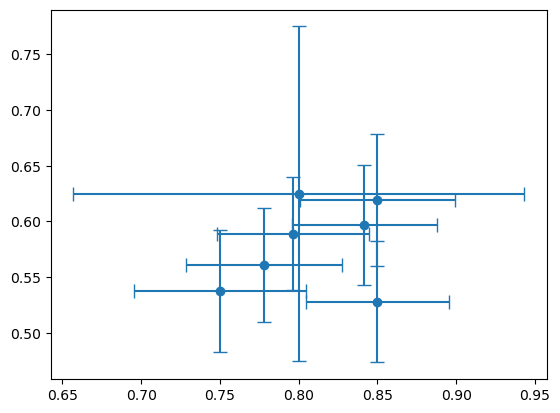

In [65]:
plt.errorbar(df_match_sota['prob_avg'], df_match_sota['prob_ind'], xerr=df_match_sota['err_avg'], yerr=df_match_sota['err_ind'], fmt='o', capsize=5)

In [66]:
df_match_sota

,estimator,prob_avg,err_avg,prob_ind,err_ind
0,SL,0.777778,0.049590,0.561111,0.051263
1,TL,0.796296,0.048041,0.588889,0.050828
2,IPSW,0.850000,0.049488,0.619231,0.059024
3,DML,0.850000,0.045176,0.528125,0.054697
4,DR,0.750000,0.054784,0.537500,0.054629
5,XL,0.841667,0.046186,0.596875,0.053746
6,CF,0.800000,0.143138,0.625000,0.150031
